In [10]:
import torch
import numpy as np, seaborn as sns, pandas as pd, matplotlib.pyplot as plt
import os, sys
sys.path.append('../../../')
sys.path.append('../../../Examples/TrackML_Quickstart')
from Pipelines.TrackML_Example_Dev.LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding

from utils import plot_true_graph, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
# DATASET_PATH = '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_all_v3'
DATASET_PATH = '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_barrel_v3'
# MODEL_PATH = '/global/cfs/cdirs/m3443/usr/pmtuan/Tracking-ML-Exa.TrkX/Examples/TrackML_Full/hpc_ckpt_5.ckpt'

In [11]:
file_list = os.listdir(DATASET_PATH)

input_data = torch.load(os.path.join(DATASET_PATH, file_list[0]))

input_data.pt/=1000

data=input_data
data

Data(x=[114073, 3], cell_data=[114073, 11], pid=[114073], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000015843', hid=[114073], pt=[114073], primary=[114073], nhits=[114073], modulewise_true_edges=[2, 46005])

number of hits that are not noise

In [12]:
(input_data.pid > 0).sum() 

tensor(55735)

In [4]:
nanpt_idx = input_data.pt.isnan()
nanpt_pid = data.pid[ nanpt_idx ]

# all noise hits have pid 0

Number of truth hits that have nan pt: 2


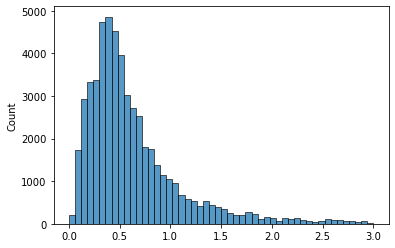

In [13]:
# pt of truth hits

truth_idx = input_data.modulewise_true_edges.unique()
truth_pt = input_data.pt[truth_idx]
print( f'Number of truth hits that have nan pt: {truth_pt.isnan().sum()}' )

sns.histplot(x=truth_pt.numpy(), binrange=(0,3), stat='count', bins=50)

plt.show()

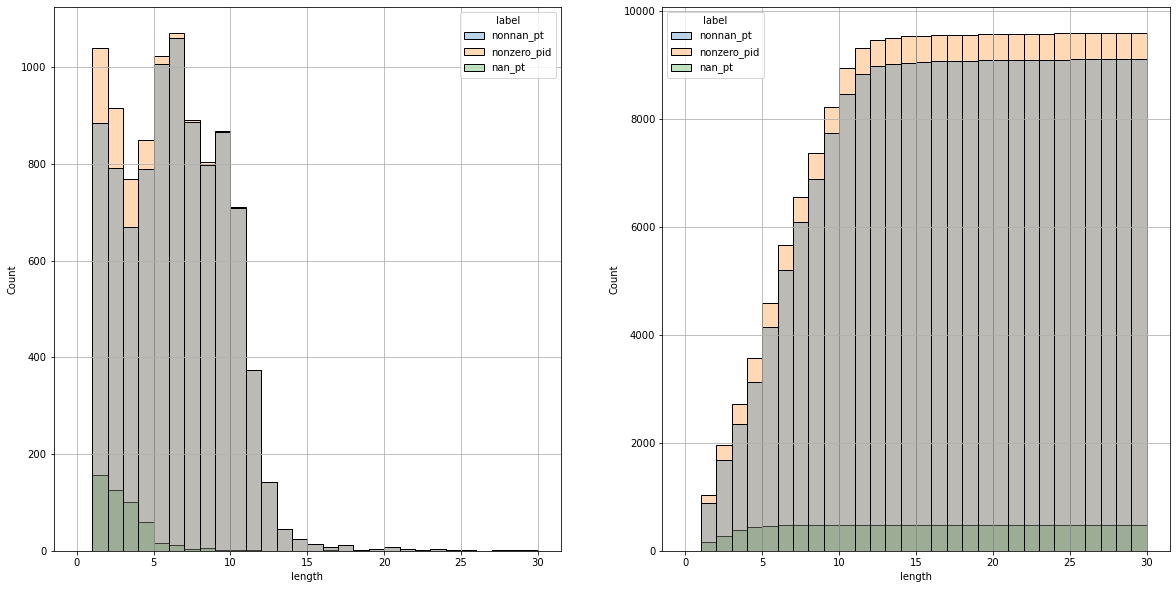

In [14]:
# hits per particle

nonzero_particle_id, nonzero_hit_count = input_data.pid[ input_data.pid > 0. ].unique(return_counts=True)
nonnan_particle_id, nonnan_hit_counts = input_data.pid[ ~ input_data.pt.isnan() ].unique(return_counts=True)
data = input_data
signal_pt = data.pt[ data.pid > 0 ]

signal_nhits = data.nhits[ data.pid>0 ]

signal_pid = data.pid[data.pid>0]

signal_pid_with_nan_pt = signal_pid[ signal_pt.isnan() ]

track_with_nan_pt_hits, n_nan_pt_hits_in_track = signal_pid_with_nan_pt.unique(return_counts=True)

particle_count = pd.concat([
    pd.DataFrame( dict(length=nonnan_hit_counts, label=['nonnan_pt']* nonnan_hit_counts.shape[0])),
    pd.DataFrame( dict(length=nonzero_hit_count, label=['nonzero_pid']*nonzero_hit_count.shape[0]) ) ,
    
    pd.DataFrame( dict(length=n_nan_pt_hits_in_track, label=['nan_pt']*n_nan_pt_hits_in_track.shape[0]) ) ,
    # pd.DataFrame( dict(length=input_data.nhits, label=['nhits']* input_data.nhits.shape[0]))
], 
    ignore_index=True
)

fig,axes = plt.subplots(1,2, figsize=(20,10))
sns.histplot(data=particle_count, x='length', hue='label', bins=30, binrange=(0,30), ax=axes[0], alpha=0.3)
sns.histplot(data=particle_count, x='length', hue='label' ,bins=30, binrange=(0,30), ax=axes[1], cumulative=True, alpha=0.3)
for ax in axes: 
    ax.grid(True)
plt.show()

These plots show that there are hits with nan pt but are themselves part of a track, sometimes long tracks

In [32]:
((input_data.pt[input_data.pid == 0]).isnan()).sum()

tensor(184534)

In [33]:
input_data.pt.isnan().sum()

tensor(191350)

In [44]:
nan_pt_pid = input_data.pid[ input_data.pt.isnan() ]
print((nan_pt_pid > 0 ).sum())
print(nan_pid.unique().shape[0])

# what are these particles with nan pt but nonzero pid? There are 1829 of them. On average, they form tracks of 3.7 hits

tensor(6816)
1830


In [73]:
noise_nhits = input_data.nhits[ noise_idx ] 

noise_nhits[noise_nhits>-1]

tensor([15,  7,  7,  ...,  6,  1,  1])

tensor(184534) tensor(0)
tensor(184534) tensor(0)
tensor([15,  7,  7,  ...,  6,  1,  1])


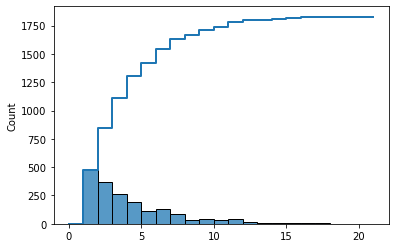

In [101]:
noise_pt = data.pt[ data.pid==0 ] 

print(noise_pt.isnan().sum(), (~noise_pt.isnan()).sum())

noise_nhits = data.nhits[ data.pid==0 ]

print( (noise_nhits==-1).sum(), (noise_nhits != -1).sum())

signal_pt = data.pt[ data.pid > 0 ]

signal_nhits = data.nhits[ data.pid>0 ]

signal_pid = data.pid[data.pid>0]

signal_pid_with_nan_pt = signal_pid[ signal_pt.isnan() ]

track_with_nan_pt_hits, n_nan_pt_hits_in_track = signal_pid_with_nan_pt.unique(return_counts=True)

print(signal_nhits[signal_pt.isnan()])

sns.histplot(x=n_nan_pt_hits_in_track.numpy(), binrange=(0,21), bins=21)
sns.histplot(x=n_nan_pt_hits_in_track.numpy(), binrange=(0,21), bins=21, cumulative=True, element='step', fill=False, lw=2)

plt.show()

<ul> Some conclusions
    <li> Hits with pid = 0 are noise. They have NaN pt and nhits = -1
    <li> There are hits with NaN pt that aren't noise, but part of a track, some times, even long tracks. The figure shows the histogram of number of nan pt per track in tracks that contain nan pt. There are quite a lot of them. 
    

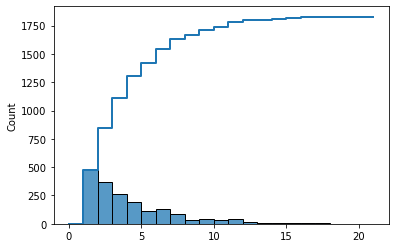

In [140]:
n_hits =[]
for idx in track_with_nan_pt_hits:
    n_hits.append( (data.pid==idx).sum().numpy())

n_hits = np.array(n_hits)

sns.histplot(x=n_hits, binrange=(0,21), bins=21)
sns.histplot(x=n_hits, binrange=(0,21), bins=21, cumulative=True, element='step', fill=False, lw=2)


plt.show()
# torch.cat( [signal_pid_with_nan_pt.unsqueeze(1), nhits_with_nan_pt.unsqueeze(1)], dim=1 )

This shows that all tracks that have a nan-pt hit are all nan-pt. So there is no track that has like 9 out of 10 hits with non-nan pt. 

In [ ]:
barrel = '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/feature_store/feature_store_modulewise_barrel_v3'

In [9]:
# edge pt cut:

edge_subset = torch.ones(data.modulewise_true_edges.shape[1]).bool()
print(edge_subset.sum())

edge_subset &= (data.pt[data['modulewise_true_edges']] > 1.0).all(0)
print(edge_subset.sum())


tensor(135612)
tensor(18617)


In [8]:
data.pt

tensor([0.4521, 0.1534,    nan,  ..., 0.3846, 0.3631,    nan],
       dtype=torch.float64)